# Imports

In [16]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Putting the data together
I am training my K-Means model on data I found on Kaggle. It contains 41106 songs with the features already extracted, but the complete dataset is divided in different files according to the decade. I chose to use this data to fit the model onto because of its variability. Btw, it appears that the dataset mentioned in the lab description (160k songs) is now private and, thus, unavailable.

In [3]:
df1 = pd.read_csv('data/00s.csv')
df2 = pd.read_csv('data/10s.csv')
df3 = pd.read_csv('data/60s.csv')
df4 = pd.read_csv('data/70s.csv')
df5 = pd.read_csv('data/80s.csv')
df6 = pd.read_csv('data/90s.csv')

In [14]:
df = pd.concat([df1, df2, df3, df4, df5, df6], axis=0)
df.reset_index(drop=True, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41106 non-null  object 
 1   artist            41106 non-null  object 
 2   uri               41106 non-null  object 
 3   danceability      41106 non-null  float64
 4   energy            41106 non-null  float64
 5   key               41106 non-null  int64  
 6   loudness          41106 non-null  float64
 7   mode              41106 non-null  int64  
 8   speechiness       41106 non-null  float64
 9   acousticness      41106 non-null  float64
 10  instrumentalness  41106 non-null  float64
 11  liveness          41106 non-null  float64
 12  valence           41106 non-null  float64
 13  tempo             41106 non-null  float64
 14  duration_ms       41106 non-null  int64  
 15  time_signature    41106 non-null  int64  
 16  chorus_hit        41106 non-null  float6

There are some features in this dataset that we have to drop, since they were presumably added by the author of the dataset, and are not present in the default results of Spotify's audio_features request.

In [29]:
df.drop(['track', 'artist', 'chorus_hit', 'sections', 'target'], axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uri               41106 non-null  object 
 1   danceability      41106 non-null  float64
 2   energy            41106 non-null  float64
 3   key               41106 non-null  int64  
 4   loudness          41106 non-null  float64
 5   mode              41106 non-null  int64  
 6   speechiness       41106 non-null  float64
 7   acousticness      41106 non-null  float64
 8   instrumentalness  41106 non-null  float64
 9   liveness          41106 non-null  float64
 10  valence           41106 non-null  float64
 11  tempo             41106 non-null  float64
 12  duration_ms       41106 non-null  int64  
 13  time_signature    41106 non-null  int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 4.4+ MB


Finally, we'll use the URI of each song as the index of the dataframe, and drop that column. This way we'll only have numerical features and we'll be able to identify the songs later.

In [31]:
df.index = df.iloc[:,0]
df = df.iloc[:, 1:]
df.index.name = None

# Connecting to Spotify's API

In [17]:
client_id = str(getpass.getpass('client_id?'))
client_secret = str(getpass.getpass('client_secret?'))

client_id?········
client_secret?········


In [18]:
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

# Scaling the data

In [39]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler()

In [43]:
df_scaled = pd.DataFrame(scaler.transform(df), columns=list(df.columns))

In [48]:
df_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.215416,-0.429668,-0.343315,0.555679,0.665030,-0.511673,0.011220,-0.508740,-0.245926,-0.039055,0.471597,-0.320853,0.251285
1,0.924004,1.086412,1.354030,0.893245,-1.503691,1.277886,-1.020031,-0.508740,-0.309525,0.544503,-0.905554,0.064804,0.251285
2,-2.124046,1.015160,1.071139,1.357892,0.665030,-0.297994,-1.074290,-0.493684,-0.159199,-0.906910,-1.112575,0.874330,0.251285
3,-1.977830,1.640592,-0.343315,1.219326,0.665030,1.080465,-1.074596,-0.250443,-0.055127,-0.783465,1.000112,0.174751,0.251285
4,0.507849,0.730153,-0.909096,1.104859,0.665030,-0.527931,-0.003533,-0.508740,-0.442506,0.331280,-0.248819,-0.345625,0.251285


In [86]:
df_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.215416,-0.429668,-0.343315,0.555679,0.665030,-0.511673,0.011220,-0.508740,-0.245926,-0.039055,0.471597,-0.320853,0.251285
1,0.924004,1.086412,1.354030,0.893245,-1.503691,1.277886,-1.020031,-0.508740,-0.309525,0.544503,-0.905554,0.064804,0.251285
2,-2.124046,1.015160,1.071139,1.357892,0.665030,-0.297994,-1.074290,-0.493684,-0.159199,-0.906910,-1.112575,0.874330,0.251285
3,-1.977830,1.640592,-0.343315,1.219326,0.665030,1.080465,-1.074596,-0.250443,-0.055127,-0.783465,1.000112,0.174751,0.251285
4,0.507849,0.730153,-0.909096,1.104859,0.665030,-0.527931,-0.003533,-0.508740,-0.442506,0.331280,-0.248819,-0.345625,0.251285


# Choosing the best K for the model
We're going to use 2 different metrics to check the different elbows formed:
- inertia
- silhouette score

In [232]:
K = range(200, 1101, 10)
inertia = []
sil = []
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled.iloc[:, :-1])
    inertia.append(model.inertia_)
    sil.append(silhouette_score(df_scaled, model.predict(df_scaled.iloc[:, :-1])))

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (91,) and (90,)

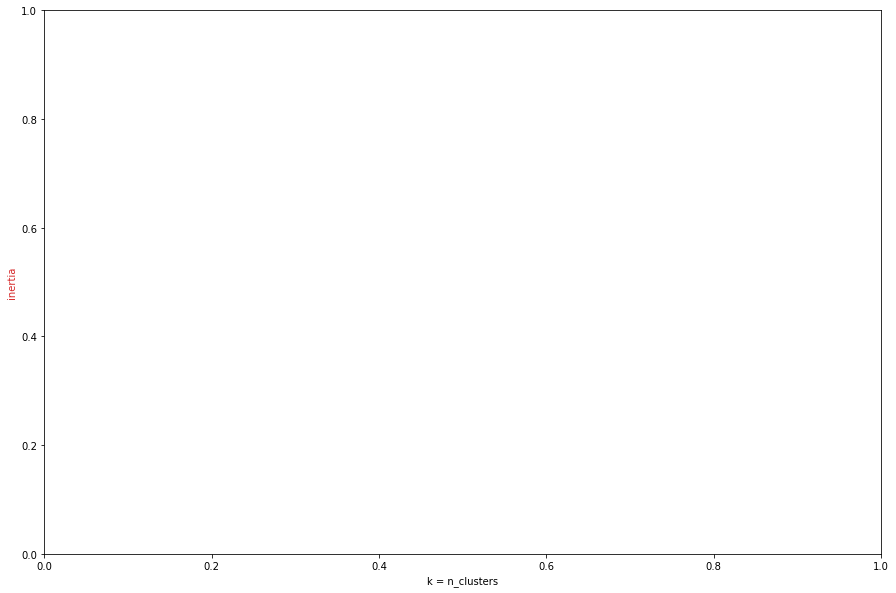

In [233]:
fig, ax1 = plt.subplots(figsize=(15,10))

color = 'tab:red'
ax1.set_xlabel('k = n_clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(K, inertia, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.locator_params(axis="x", nbins=50)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)
ax2.plot(K, sil, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show();

Previously, many other ranges were tried (in total, approximately from 5 to 1200). By looking at the elbows formed at the plot, we'll go with k=23. There seems to be the slightest elbow for inertia values there, and the silhouette is almost the highest (very close to k=1100) with presumably a lower processing time.

# Assembling the final model with k=950

In [239]:
kmeans = KMeans(n_clusters=950, random_state=42)
KMM = kmeans.fit(df_scaled)

In [241]:
df_cluster = df_scaled
df_cluster['cluster'] = KMM.labels_
df_cluster['cluster'].value_counts()

120    138
359    136
107    132
274    130
439    125
      ... 
723      2
149      2
314      2
884      2
671      1
Name: cluster, Length: 950, dtype: int64

## Pickling the model to use it another time

In [242]:
import pickle
filename = 'cm_model.sav'
pickle.dump(KMM, open(filename, 'wb'))

# Integrating the model to the recommender flow (see flow chart in the repo)

In [243]:
def spotify_display(song_name_id):
    from IPython.core.display import display
    from IPython.display import IFrame
    display(IFrame(src=f"https://open.spotify.com/embed/track/{song_name_id}",
                    width="320",
                    height="80",
                    frameborder="0",
                    allowtransparency="true",
                    allow="encrypted-media",))

In [244]:
from fun import *
top100 = top100()

In [253]:
song_sp = sp.search('Forever Young', type='track')

In [256]:
song_sp['tracks']['items'][0]['uri']

'spotify:track:4S1VYqwfkLit9mKVY3MXoo'

In [ ]:
def recommender_clustering():
    # Imports
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials
    import getpass
    import pandas as pd
    import numpy as np
    from fuzzywuzzy import fuzz
    # Main loop
    go_again = True
    while go_again:
        song = input('Write the title of a song you like to find similar ones: ')
        best_match = ()
        # Getting the best match from billboard Hot100 using Levenshtein's ratio
        for index, name in top100['song_title'].iteritems():
            ratio = fuzz.partial_ratio(name.lower(), song.lower())
            if len(best_match) == 0:
                best_match = (index, ratio)
            else:
                if ratio > best_match[1]:
                    best_match = (index, ratio)
        # Match in Hot100
        while True:
            print("\nI'm checking the Billboard Hot 100 first.")
            prompt = input(f'\nIs your song {top100.iloc[best_match[0]].song_title} by {top100.iloc[best_match[0]].artists}? Type yes/no: ')
            # Song in Hot100, recommend another one from the list.
            if prompt.lower() == 'yes':
                pick = top100.drop(best_match[0]).sample()
                song_title = pick.song_title.item()
                artist = pick.artists.item()
                recommendation = f'{song_title} by {artist}'
                print(f'\nNice choice! Try listening to {recommendation}, which another HOT song.')
                break
            elif prompt.lower() == 'no':
                # Song not in Hot100, search in Spotify and promp user to confirm again
                print("\nOkay, let me find a better match in Spotify...")
                song_sp = sp.search(song, type='track')
                if len(song_sp['tracks']['items']) == 0:
                    print("\nSorry, I didn't catch that!")
                else:
                    while True:
                        song_name = song_sp['tracks']['items'][0]['name']
                        artist_name = song_sp['tracks']['items'][0]['artists'][0]['name']
                        prompt = input(f'\nOkay, I found something! Are you referring to {song_name} by {artist_name}? Type yes/no: ')
                        if prompt.lower() == 'yes':
                            id_recom = song_sp['tracks']['items'][0]['id']
                            uri = song_sp['tracks']['items'][0]['uri']
                            feat = sp.audio_features(tracks=[id_recom])[0]
                            keys_to_remove = ["id", "uri", "track_href", "analysis_url", "type"]
                            for key in keys_to_remove:
                                feat.pop(key)
                            col_names = list(df_cluster.drop(['cluster'], axis=1).columns)
                            new_song = pd.DataFrame(data = feat, columns=col_names, index=[0])
                            new_song_scaled = pd.DataFrame(scaler.transform(new_song), columns=col_names)
                            cluster = KMM.predict(new_song_scaled)[0]
                            print(f"\nThe predicted cluster for the song {song_name} is {cluster}")
                            index = df_cluster[df_cluster.cluster == cluster].sample().index.values[0]
                            while uri == df.iloc[index].name:
                                index = df_cluster[df_cluster.cluster == cluster].sample().index.values[0]
                            recom = sp.track(df.iloc[index].name)
                            song_recom = recom['name']
                            artist_recom = recom['artists'][0]['name']
                            print(f'\nNice! Then try listening to {song_recom} by {artist_recom}. You can listen to it now!')
                            spotify_display(recom['id'])
                            recom_cluster = round(df_cluster.iloc[index].cluster.item())
                            print(f'\nThe cluster of the recommended song is {recom_cluster}')
                            break
                        elif prompt.lower() == 'no':
                            print("\nI'm sorry, I can't seem to find the song you're looking for!")
                            break
                        else:
                            print("\nSorry, I didn't catch that, you need to type either 'yes' or 'no'.")
                break
            else:
                print("\nSorry, I didn't catch that, you need to type either 'yes' or 'no'.")
        
        while True:
            again = input('\nDo you wanna use the awesome recommender again? Type yes/no: ')
            if again.lower() == 'no':
                go_again = False
                print('\nOk, thanks for using the awesome recommender!')
                break
            elif again.lower() == 'yes':
                break
            else:
                 print("\nSorry, I didn't catch that, you need to type either 'yes' or 'no'.")




In [267]:
recommender_clustering()

Write the title of a song you like to find similar ones: tame pixies

I'm checking the Billboard Hot 100 first.

Is your song Surface Pressure by Jessica Darrow? Type yes/no: no

Okay, let me find a better match in Spotify...

Okay, I found something! Are you referring to Tame by Pixies? Type yes/no: yes



The predicted cluster for the song Tame is 307

Nice! Then try listening to Cattle In The Cane by Norman Blake. You can listen to it now!



The cluster of the recommended song is 307

Do you wanna use the awesome recommender again? Type yes/no: no

Ok, thanks for using the awesome recommender!
